In [2]:
ROOT_PATH = '../../../../'

import sys
import os
import inspect
from collections import OrderedDict
from functools import partial

sys.path.append(ROOT_PATH)

import pyro
import torch
import torchvision
import glob
import tqdm
import torch.nn.functional as F
import torch_geometric.nn as gnn
import torch_geometric.transforms as gnn_T
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch_cluster import grid_cluster
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MNISTSuperpixels, CoraFull
from torch_geometric.data import Batch, DataLoader

In [3]:
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{torch.__version__[0:5:2]}"
])
!pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
!pip install plotly

Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py38_cu102_pyt171/download.html


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
%matplotlib inline

## Setup and Data Inspection

In [ ]:
from pytorch3d.utils import ico_sphere
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import chamfer_distance
from pytorch3d.vis.plotly_vis import plot_scene

In [7]:
from mpl_toolkits.mplot3d import Axes3D
!wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj

--2021-04-16 01:28:58--  https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 2606:4700:10::6816:4a8e, 2606:4700:10::6816:4b8e, 2606:4700:10::ac43:904, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|2606:4700:10::6816:4a8e|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156763 (153K) [text/plain]
Saving to: ‘dolphin.obj.1’

dolphin.obj.1       100%[===================>] 153.09K   296KB/s    in 0.5s    

2021-04-16 01:29:00 (296 KB/s) - ‘dolphin.obj.1’ saved [156763/156763]



In [91]:
sphere_mesh = ico_sphere(level=3)
verts, faces, _ = load_obj("dolphin.obj")
test_mesh = Meshes(verts=[verts], faces=[faces.verts_idx])

samples = 1000
sample_sphere = sample_points_from_meshes(sphere_mesh, samples)
sample_test = sample_points_from_meshes(test_mesh, samples)
loss_chamfer, _ = chamfer_distance(sample_sphere, sample_test)

In [92]:
from mpl_toolkits.mplot3d import Axes3D

def plot_pointcloud(mesh, title="", samples=500):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, samples)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

<ipython-input-92-b3470e555ec7>:8: MatplotlibDeprecationWarning:

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.



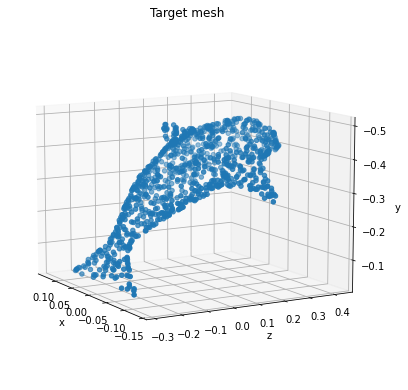

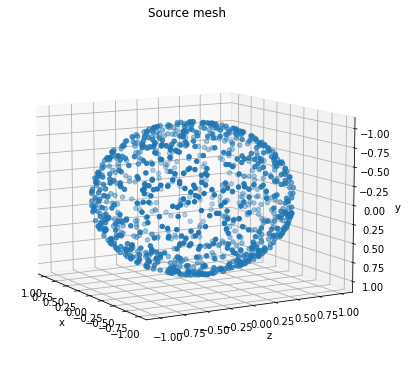

In [93]:
plot_pointcloud(test_mesh, "Target mesh", samples)
plot_pointcloud(sphere_mesh, "Source mesh", samples)

In [95]:
sphere_mesh = ico_sphere(level=3)
print(sphere_mesh.verts_list()[0].shape)
fig = plot_scene({
    "subplot1": {
        "torus_mesh": sphere_mesh
    }
})
fig.show()

torch.Size([642, 3])


<ipython-input-92-b3470e555ec7>:8: MatplotlibDeprecationWarning:

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.



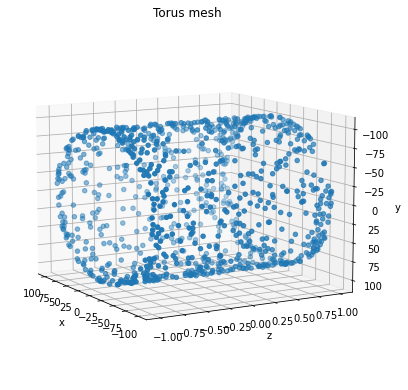

In [96]:
from pytorch3d.utils import torus


torus_mesh = torus(r=1, R=100, sides=n, rings=n)
plot_pointcloud(torus_mesh, "Torus mesh", samples)

In [103]:
n = 100
torus_mesh = torus(r=20, R=100, sides=4, rings=n)
sampled_torus_verts = sample_points_from_meshes(torus_mesh, 1000)
# sampled_torus_mesh = Meshes(verts=sampled_torus_verts)
print(sampled_torus_verts.verts_list())

# print(torus_mesh.verts_list()[0].shape)
fig = plot_scene({
    "original": {
        "torus_mesh": torus_mesh,
    },
#     "sub-sampled": {
#         "torus_mesh": sampled_torus_mesh,
#     }
})
fig.show()

AttributeError: 'Tensor' object has no attribute 'verts_list'

In [107]:
sampled_torus_verts[0].shape

torch.Size([1000, 3])

### Applying Transformations

In [18]:
sphere_mesh = ico_sphere(level=3)

scale_x = 1
scale_y = scale_x - 0.3
scale_z = scale_x * 2.5
transformation_matrix = [
    [scale_x, 0, 0],
    [0, scale_y, 0],
    [0, 0, scale_z],
]

transformed_verts = np.dot(sphere_mesh.verts_list()[0], transformation_matrix)

sphere_mesh_transformed = Meshes(
    verts=[torch.tensor(transformed_verts)],
    faces=sphere_mesh.faces_list(),
)

fig = plot_scene({
    "transformed": {
        "sphere_mesh": sphere_mesh_transformed,
    },
    "original": {
        "sphere_mesh": sphere_mesh,
    },
})
fig.show()

In [20]:
from pytorch3d.utils import torus

n = 5
torus_mesh = torus(r=50, R=100, sides=n, rings=n)

transformed_verts = np.dot(torus_mesh.verts_list()[0], transformation_matrix)

torus_mesh_transformed = Meshes(
    verts=[torch.tensor(transformed_verts)],
    faces=torus_mesh.faces_list(),
)

sampled_torus_verts = sample_points_from_meshes(torus_mesh, 10000)
print(sampled_torus_verts.shape)
print(torus_mesh.verts_list()[0].shape)

fig = plot_scene({
    "transformed": {
        "sphere_mesh": torus_mesh_transformed,
    },
    "original": {
        "sphere_mesh": torus_mesh,
    },
})
fig.show()

torch.Size([1, 10000, 3])
torch.Size([25, 3])


Code adapted from https://github.com/theswgong/coma/blob/master/models/networks.py

## CoMA

In [30]:
sys.path.append('/vol/bitbucket/rrr2417/coma')

In [37]:
from psbody.mesh import Mesh
from pytorch3d.utils import ico_sphere
from torch.utils.data import DataLoader

from models import AE
from utils import utils, writer, train_eval, mesh_sampling

In [ ]:
dataset = sphere_mesh.verts_list()[0] \
    .to(device) \
    .unsqueeze(0) \
    .repeat(1000, 1, 1)

In [38]:
template_mesh = ico_sphere(level=3)

mesh = Mesh(
    v=template_mesh.verts_list()[0].detach().cpu().numpy(),
    f=template_mesh.faces_list()[0].detach().cpu().numpy()
)
ds_factors = [4, 4, 4, 4]
_, A, D, U, F = mesh_sampling.generate_transform_matrices(mesh, ds_factors)
tmp = {'face': F, 'adj': A, 'down_transform': D, 'up_transform': U}

edge_index_list = [
    utils.to_edge_index(adj).to(device)
    for adj in tmp['adj']
]
down_transform_list = [
    utils.to_sparse(down_transform).to(device)
    for down_transform in tmp['down_transform']
]
up_transform_list = [
    utils.to_sparse(up_transform).to(device)
    for up_transform in tmp['up_transform']
]

Generating transform matrices...


In [60]:
in_channels = 3
out_channels = [16, 16, 16, 32]
latent_channels = 8
K = 6

model = AE(in_channels,
           out_channels,
           latent_channels,
           edge_index_list,
           down_transform_list,
           up_transform_list,
           K=K).to(device)

model

AE(
  (en_layers): ModuleList(
    (0): Enblock(
      (conv): ChebConv(3, 16, K=6, normalization=sym)
    )
    (1): Enblock(
      (conv): ChebConv(16, 16, K=6, normalization=sym)
    )
    (2): Enblock(
      (conv): ChebConv(16, 16, K=6, normalization=sym)
    )
    (3): Enblock(
      (conv): ChebConv(16, 32, K=6, normalization=sym)
    )
    (4): Linear(in_features=96, out_features=8, bias=True)
  )
  (de_layers): ModuleList(
    (0): Linear(in_features=8, out_features=96, bias=True)
    (1): Deblock(
      (conv): ChebConv(32, 32, K=6, normalization=sym)
    )
    (2): Deblock(
      (conv): ChebConv(32, 16, K=6, normalization=sym)
    )
    (3): Deblock(
      (conv): ChebConv(16, 16, K=6, normalization=sym)
    )
    (4): Deblock(
      (conv): ChebConv(16, 16, K=6, normalization=sym)
    )
    (5): ChebConv(16, 3, K=6, normalization=sym)
  )
)

In [69]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(dataset, batch_size=100, shuffle=False)
test_loader = DataLoader(dataset, batch_size=100, shuffle=False)

epochs = 5
train_eval.run(model, train_loader, test_loader, epochs, optimizer, device)

# train_eval.run(model, train_loader, test_loader, args.epochs, optimizer,
#                scheduler, writer, device)
# train_eval.eval_error(model, test_loader, device, meshdata, args.out_dir)

1. train_loss: 0.18961, test_loss: 0.09988396614789963
2. train_loss: 0.0699, test_loss: 0.04880761727690697
3. train_loss: 0.04285, test_loss: 0.03295302763581276
4. train_loss: 0.03018, test_loss: 0.026091793552041054
5. train_loss: 0.02154, test_loss: 0.01877090148627758


In [70]:
out = model(dataset[0].unsqueeze(0))

sphere_mesh_pred = Meshes(
    verts=[out[0].cpu().clone().detach()],
    faces=template_mesh.faces_list(),
)

<ipython-input-9-b3470e555ec7>:8: MatplotlibDeprecationWarning:

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.



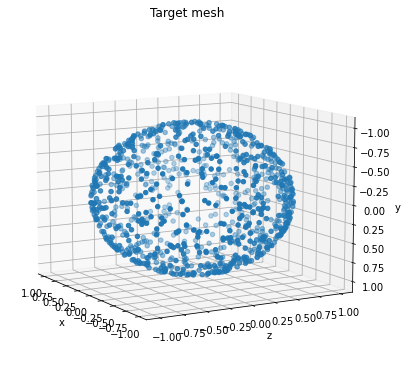

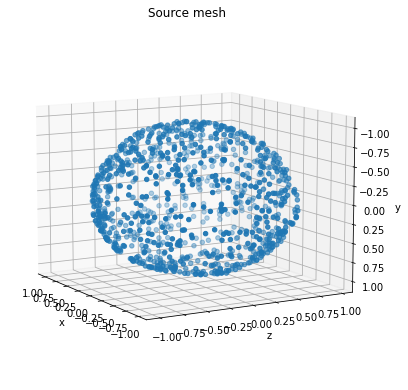

In [72]:
plot_pointcloud(template_mesh, "Target mesh", samples)
plot_pointcloud(sphere_mesh_pred, "Source mesh", samples)

----------------------------

In [ ]:
from sklearn.metrics import average_precision_score, accuracy_score

def train_gvae(model, train_dataset_loader, optimiser, preprocessor, device):
    model.train()
    
    for batch in tqdm.tqdm(train_dataset_loader):
        optimiser.zero_grad()
        batch = preprocessor(batch.to(device))
        edge_probs, z, mean, log_std = model(batch.x, batch.edge_index, batch.edge_attr)
        loss, _, _ = model.loss_function(mean, log_std, edge_probs)
        loss.backward()
        optimiser.step()

def validate_gvae(model, val_dataset_loader, preprocessor, device):
    model.eval()
    
    with torch.no_grad():

        val_elbos = []
        log_lik = []
        kl_losses = []
        average_precisions = []
        accuracies = []

        for batch in tqdm.tqdm(val_dataset_loader):
            # Forward Pass
            batch = preprocessor(batch.to(device))
            edge_probs, z, mean, log_std = model(batch.x, batch.edge_index, batch.edge_attr)
            elbo, log_prob, kl_loss = model.loss_function(mean, log_std, edge_probs)
            # Accumulate Metrics
            val_elbos.append(elbo)
            log_lik.append(log_prob)
            kl_losses.append(kl_loss)
            ones = torch.ones_like(edge_probs.cpu())
            ap = average_precision_score(ones, edge_probs.cpu())
            average_precisions.append(ap)
            mask = edge_probs > 0.5
            edge_probs[mask] = 1
            edge_probs[~mask] = 0
            acc = accuracy_score(ones, edge_probs.cpu())
            accuracies.append(acc)
            
    total_elbo = sum(val_elbos) / len(val_elbos)
    total_log_lik = sum(log_lik) / len(log_lik)
    total_kl = sum(kl_losses) / len(kl_losses)
    ap = sum(average_precisions) / len(average_precisions)
    acc = sum(accuracies) / len(accuracies)
    
    return total_elbo, total_log_lik, total_kl, ap, acc

In [ ]:
graph_train_dataset = CoraFull(root=dataset_folder)
graph_test_dataset = CoraFull(root=dataset_folder)

In [ ]:
epochs = 0

train_frac = 0.8
train_idx = int(len(graph_train_dataset) * train_frac)
train_split = graph_train_dataset[:train_idx]
val_split = graph_train_dataset[train_idx:]

batch_size = 512
graph_train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=False)
graph_val_loader = DataLoader(val_split, batch_size=batch_size, shuffle=False)

In [ ]:
from torch import Tensor
from torch_geometric.nn import DeepGCNLayer


LOG_CONST = 1e-15


class SplineConvUnit(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim, edge_dim, dropout=0, latent_encoder=False):
        super(SplineConvUnit, self).__init__()
        self.edge_dim = edge_dim
        self.dropout = dropout
        self.conv = gnn.SplineConv(input_dim, output_dim, dim=edge_dim, kernel_size=5)
        self.latent_encoder = latent_encoder
        
    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
        x = self.conv(x, edge_index, edge_attr)
        
        if self.latent_encoder:
            return x
        
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout)
        
        return x
    

class GCNConvUnit(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim, edge_dim, dropout=0, latent_encoder=False):
        super(GCNConvUnit, self).__init__()
        self.dropout = dropout
        self.conv = gnn.GCNConv(input_dim, output_dim)
        self.latent_encoder = latent_encoder
        
    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
        x = self.conv(x, edge_index)
        
        if self.latent_encoder:
            return x
        
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout)
        
        return x
    

class CoMAUnit(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim, edge_dim, dropout=0, latent_encoder=False):
        super(CoMAUnit, self).__init__()
        self.dropout = dropout
        self.conv = gnn.GCNConv(input_dim, output_dim)
        self.latent_encoder = latent_encoder
        
    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
        x = self.conv(x, edge_index)
        
        if self.latent_encoder:
            return x
        
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout)
        
        return x


class Encoder(torch.nn.Module):
    
    def __init__(self, conv_class, input_dim, hidden_dim1, hidden_dim2, latent_dim, edge_dim=None, dropout=0):
        super(Encoder, self).__init__()
        self.conv1 = conv_class(input_dim, hidden_dim1, edge_dim, dropout)
        self.conv2 = conv_class(hidden_dim1, hidden_dim2, edge_dim, dropout)
        
        kwargs = {
            'input_dim': hidden_dim2,
            'output_dim': latent_dim,
            'edge_dim': edge_dim,
            'latent_encoder': True,
        }
        
        if conv_class == SplineConvUnit:
            kwargs['edge_dim'] = edge_dim
        
        self.mean = conv_class(**kwargs)
        self.log_std = conv_class(**kwargs)
        self.edge_dim = edge_dim
        self.dropout = dropout
    
    def get_output_dim(self):
        return self.output_dim
    
    def get_edge_dim(self):
        return self.edge_dim

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> [Tensor, Tensor]:
        x = self.conv1(x, edge_index, edge_attr)
        x = self.conv2(x, edge_index, edge_attr)
        mean = self.mean(x, edge_index, edge_attr)
        log_std = self.log_std(x, edge_index, edge_attr)
        return mean, log_std
    

class GraphVAE(torch.nn.Module):
    """
    https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.py
    """
    
    def __init__(self, encoder, decoder):
        super(GraphVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def encode(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> [Tensor, Tensor]:
        return self.encoder(x, edge_index, edge_attr)
    
    def decode(self, z: Tensor, edge_index: Tensor) -> Tensor:
        return self.decoder(z, edge_index)
    
    def reparametrise(self, mean: Tensor, log_std: Tensor) -> Tensor:
        std = torch.exp(log_std)
        
        # Note: Just 1 MC particle
        eps = torch.randn_like(std)
        z = mean + eps * std
        
        return z
    
    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> [Tensor, Tensor, Tensor, Tensor]:
        res = self.encode(x, edge_index, edge_attr)
        mean, log_std = self.encode(x, edge_index, edge_attr)
        z = self.reparametrise(mean, log_std)
        return self.decode(z, edge_index), z, mean, log_std

    def generate(self, x: Tensor) -> Tensor:
        return self.forward(x)[0]
    
    def loss_function(self, mean: Tensor, log_std: Tensor, pos_edge_probs: Tensor) -> Tensor:
        pos_log_prob = -torch.log(pos_edge_probs + LOG_CONST).mean()
        # neg_log_prob = -torch.log(1 - neg_edge_probs + LOG_CONST).mean()
        log_prob = pos_log_prob  # + neg_log_prob
        
        kl_loss = torch.sum(1 + 2 * log_std - mean ** 2 - log_std.exp() ** 2, dim=1)
        kl_loss = -0.5 * torch.mean(kl_loss)
        
        loss = log_prob + kl_loss
        
        return loss, log_prob, kl_loss

In [ ]:
preprocess = gnn_T.Compose([
    gnn_T.TargetIndegree()
])

In [ ]:
from torch_geometric.nn import InnerProductDecoder

input_dim = 1
hidden1 = 64
hidden2 = 32
edge_dim = 2
latent_dim = 16
dropout = 0.5

conv_class = GCNConvUnit
encoder = Encoder(conv_class, input_dim, hidden1, hidden2, latent_dim, edge_dim, dropout).to(device)
decoder = InnerProductDecoder().to(device)
gvae = GraphVAE(encoder, decoder).to(device)

gvae

In [ ]:
Data shape
Batch(batch=[19793], edge_attr=[126842, 1], edge_index=[2, 126842], x=[19793, 8710], y=[19793])
torch.Size([19793, 8710]) torch.Size([2, 126842]) torch.Size([126842, 1])

In [ ]:
graph_trial_loader = DataLoader(graph_train_dataset, batch_size=1, shuffle=False)

for x in graph_trial_loader:
    break

gvae.eval()
    
_data = preprocess(x.to(device))

print('Data shape')
print(_data)
print(_data.x.shape, _data.edge_index.shape, _data.edge_attr.shape)
print()

edge_probs, z, mean, log_std = gvae(_data.x, _data.edge_index, _data.edge_attr)
print('Output shape')
print(edge_probs.shape, z.shape, mean.shape, log_std.shape)
print()

print(gvae.loss_function(mean, log_std, edge_probs))
# Calculate accuracy + precision etc. using 1 as the target

In [ ]:
_data.batch

In [ ]:
_x, _batch = to_dense_batch(_data.x, _data.batch)
_x.shape, _batch.shape

In [ ]:
optimiser_gvae = torch.optim.Adam(gvae.parameters(), lr=0.001)

for epoch in range(5):
    
    print(f'Epoch: {epoch}')
    print('Training')
    train_gvae(gvae, graph_train_loader, optimiser_gvae, preprocess, device)
    print('Validation - Val set')
    mean_val_elbo, mean_val_log_lik, mean_val_total_kl, val_ap, val_acc = validate_gvae(gvae, graph_val_loader, preprocess, device)
    print('Validation - Train set')
    mean_train_elbo, mean_train_log_lik, mean_train_total_kl, train_ap, train_acc = validate_gvae(gvae, graph_train_loader, preprocess, device)
    
    print(f'Train Elbo: {mean_train_elbo}, Val Elbo: {mean_val_elbo}')
    print(f'Train Log Lik: {mean_train_log_lik}, Val Log Lik: {mean_val_log_lik}')
    print(f'Train KL: {mean_train_total_kl}, Val KL: {mean_val_total_kl}')
    print(f'Train AP: {train_ap}, Val AP: {val_ap}')
    print(f'Train Acc: {train_acc}, Val Acc: {val_acc}')
    print()